In [ ]:
import re
import seaborn as sns
import threading
import torch
import pandas as pd
from tqdm import tqdm
from copy import deepcopy

from dataclasses import dataclass, fields, asdict
from abc import ABC, abstractmethod
from model.model import PageAccModel
from logfile_reader import read_pages, save_pages_accs, read_optimal_results, Page

# Load data

In [3]:
pages = read_pages("train_data/acc_logfile2")

In [4]:
save_pages_accs("train_data/acc_logfile2_pages")

In [5]:
print(len(pages))

1024067


In [6]:
optimal_results = read_optimal_results("train_data/acc_logfile2_victims")

In [7]:
len(optimal_results)

1024067

In [22]:
TRAIN_SIZE = len(pages)
BATCH_SIZE = 2
BUFFER_SIZE = 32

In [9]:
TRAIN_SIZE

1024067

# Analyse data

In [10]:
sum([page.hit for page in pages[:TRAIN_SIZE]]) / TRAIN_SIZE

0.6318912727389907

In [11]:
# find_optimal_hit_rate([page.buffer for page in pages[:TRAIN_SIZE]], BUFFER_SIZE)
sum([1 if len(victims) == 0 else 0 for victims in optimal_results[:TRAIN_SIZE]]) / TRAIN_SIZE

0.6844718167854251

<Axes: ylabel='Count'>

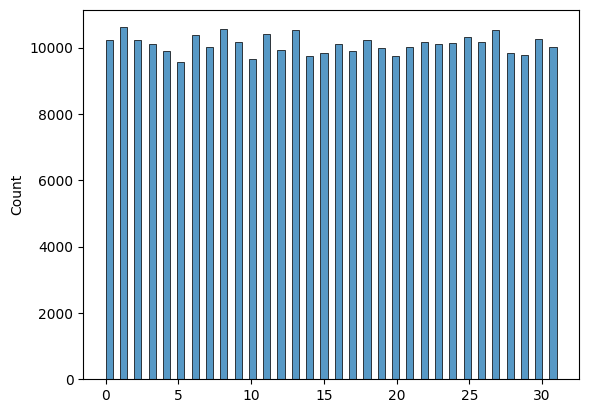

In [12]:
sns.histplot([victims[0][0] for victims in optimal_results[:TRAIN_SIZE] if len(victims) != 0])

<Axes: xlabel='None'>

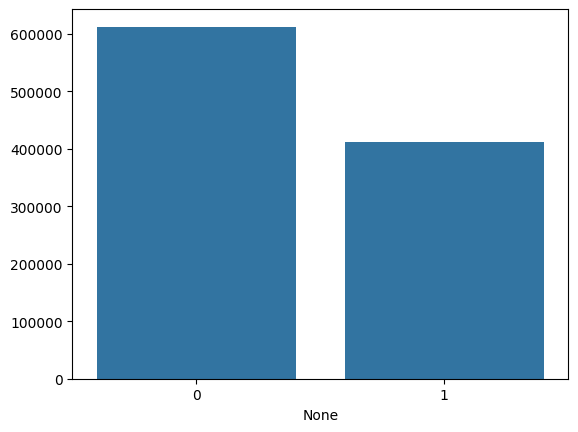

In [13]:
# sns.histplot([page.is_local_temp for page in pages], discrete=True)
# sns.histplot([page.mode for page in pages], discrete=True)

# sns.histplot([page.relam for page in pages], discrete=True)
data = pd.Series([page.relminmxid for page in pages])
value_counts = data.value_counts()
sns.barplot(x=value_counts.index, y=value_counts.values)


# Train

In [25]:
def get_model_optimal_res(pages, buffer, current_index):
    res = [0] * (len(buffer))
    if (current_index >= len(pages)):
        print(f"ERROR: current_index=={current_index} pages.size() == {len(pages)}")


    page_in_buffer = next(filter(lambda x: x[1].buffer == pages[current_index].buffer, enumerate(buffer)), None)
    if page_in_buffer is not None:
        return res, page_in_buffer[0]
    
    empty_pages = [index for index, value in enumerate(buffer) if value.buffer == -1]
    if len(empty_pages) > 0:
        for i in empty_pages:
            res[i] = 1 / len(empty_pages)
        
        return res, empty_pages[0]
    
    # victims_rates = optimal_results[current_index]
    # victim_rates_sum = sum([victim[1] for victim in victims_rates])
    # for victim, rate in victims_rates:
    #     res[victim] = rate / victim_rates_sum
    victims_rates = optimal_results[current_index]
    res[victims_rates[0][0]] = 1

    return res, victims_rates[0][0]

In [17]:
def get_train_data(pages, buffer, batch_start, batch_end):
    pages_acc = torch.Tensor([list(asdict(page).values()) for page in pages[batch_start:batch_end]])

    buffers = []
    optimal_predictions = []
    hit_fail_mask = []

    for i in range(batch_start, batch_end):
        buffers.append([value for obj in buffer for value in asdict(obj).values()])

        res, victim = get_model_optimal_res(pages, buffer, i)
        optimal_predictions.append(res)

        if sum(res) > 0:
            buffer[victim] = deepcopy(pages[i])
            buffer[victim].hit = victim
            pages_acc[i - batch_start][-1] = BUFFER_SIZE
            hit_fail_mask.append(1)
        else:
            pages_acc[i - batch_start][-1] = victim
            hit_fail_mask.append(0)
    
    return pages_acc, torch.Tensor(buffers), torch.Tensor(optimal_predictions), buffer, torch.tensor(hit_fail_mask, dtype=torch.bool)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [26]:
model = PageAccModel(len(fields(Page)), 256, 512, BUFFER_SIZE).to(device)

In [27]:
loss = torch.nn.CrossEntropyLoss(reduction='none') # Установим 'none' для получения потерь по каждому элементу
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

f = open("train.txt", "w")

h, c = None, None
model.train()
for epoch in range(5):
    buffer = [Page(-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0)] * BUFFER_SIZE

    loss_sum = 0
    pbar = tqdm(range(0, TRAIN_SIZE, BATCH_SIZE))
    for i in pbar:
        batch_start = i
        # batch_end = i + BATCH_SIZE if i + BATCH_SIZE < TRAIN_SIZE else TRAIN_SIZE
        batch_end = i + BATCH_SIZE
        if batch_end >= TRAIN_SIZE:
            continue
        pages_acc, buffers, optimal_predictions, buffer, hit_fail_mask = get_train_data(pages, buffer, batch_start, batch_end)
        optimal_predictions = torch.argmax(optimal_predictions, dim=1)
    
        optimizer.zero_grad()

        out, h, c = model.forward(pages_acc.to(device), buffers.to(device), h, c)
        h.to(device)
        c.to(device)

        losses = loss(out, optimal_predictions.to(device))
        masked_losses = losses[hit_fail_mask]
        loss_value = masked_losses.mean()
    
        loss_value.backward()

        f.write("=========================\n")
        for i in range(len(hit_fail_mask)):
            if hit_fail_mask[i]:
                f.write(f"{i}. ////\n")
                f.write(f"{out[i]}\n")
                f.write(f"{optimal_predictions[i]}\n")

                for name, param in model.named_parameters():
                    if param.grad is not None:
                        f.write(f"{name}: {param.grad.abs().mean()}\n")

                f.write("////\n")
        f.write("=========================\n")

        optimizer.step()
    
        h = h.detach()
        c = c.detach()

        loss_sum += loss_value.item()
        loss_avg = loss_sum / (batch_end // BATCH_SIZE)

        pbar.set_postfix_str(f"loss={loss_avg}")

f.close()

  0%|          | 2/512034 [00:00<9:38:14, 14.76it/s, loss=nan]    

tensor([[ 1.,  0.,  0.,  2.,  0.,  1.,  0., 17.,  0.,  0., 32.],
        [ 2.,  0.,  0.,  2.,  0.,  1.,  0., 12.,  0.,  0., 32.]])
[1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
tensor([[ 2.,  0.,  0.,  2.,  0.,  1.,  0., 12.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  2.,  0.,  1.,  0., 17.,  0.,  0.,  0.]])
[1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
tensor([[ 1.,  0.,  0.,  2.,  0.,  1.,  0., 17.,  0.,  0.,  0.],
        [ 3.,  0.,  0.,  2.,  0.,  1.,  0., 33.,  0.,  0., 32.]])
[1, 2, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
tensor([[ 4.,  0.,  1.,  2.,  0.,  1.,  0., 33.,  0.,  0., 32.],
        [ 5.,  0.,  2.,  2.,  0.,  1.,  0., 33.,  0.,  0., 32.]])
[1, 2, 3, 4, 5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

  0%|          | 6/512034 [00:00<9:15:36, 15.36it/s, loss=nan]

tensor([[ 6.,  0.,  3.,  2.,  0.,  1.,  0., 33.,  0.,  0., 32.],
        [ 7.,  0.,  0.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.]])
[1, 2, 3, 4, 5, 6, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
tensor([[ 8.,  0.,  1.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.],
        [ 9.,  0.,  2.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.]])
[1, 2, 3, 4, 5, 6, 7, 8, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
tensor([[10.,  0.,  3.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.],
        [11.,  0.,  4.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.]])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
tensor([[12.,  0.,  5.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.],
        [13.,  0.,  6.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.]])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

  0%|          | 10/512034 [00:00<9:10:04, 15.51it/s, loss=nan]

tensor([[14.,  0.,  7.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.],
        [15.,  0.,  8.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.]])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
tensor([[16.,  0.,  9.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.],
        [17.,  0., 10.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.]])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
tensor([[18.,  0., 11.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.],
        [19.,  0., 12.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.]])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
tensor([[20.,  0., 13.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.],
        [21.,  0., 14.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.]])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

  0%|          | 14/512034 [00:00<8:59:53, 15.81it/s, loss=nan]

tensor([[22.,  0., 15.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.],
        [ 7.,  0., 16.,  2.,  0.,  1.,  0., 26.,  0.,  0.,  6.]])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
tensor([[ 8.,  0., 17.,  2.,  0.,  1.,  0., 26.,  0.,  0.,  7.],
        [ 9.,  0., 18.,  2.,  0.,  1.,  0., 26.,  0.,  0.,  8.]])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
tensor([[10.,  0., 19.,  2.,  0.,  1.,  0., 26.,  0.,  0.,  9.],
        [11.,  0., 20.,  2.,  0.,  1.,  0., 26.,  0.,  0., 10.]])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
tensor([[12.,  0., 21.,  2.,  0.,  1.,  0., 26.,  0.,  0., 11.],
        [13.,  0., 22.,  2.,  0.,  1.,  0., 26.,  0.,  0., 12.]])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

  0%|          | 18/512034 [00:01<9:29:53, 14.97it/s, loss=nan]

tensor([[14.,  0., 23.,  2.,  0.,  1.,  0., 26.,  0.,  0., 13.],
        [15.,  0., 24.,  2.,  0.,  1.,  0., 26.,  0.,  0., 14.]])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
tensor([[16.,  0., 25.,  2.,  0.,  1.,  0., 26.,  0.,  0., 15.],
        [ 3.,  0.,  0.,  2.,  0.,  1.,  0., 33.,  0.,  0.,  2.]])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
tensor([[ 4.,  0.,  1.,  2.,  0.,  1.,  0., 33.,  0.,  0.,  3.],
        [ 5.,  0.,  2.,  2.,  0.,  1.,  0., 33.,  0.,  0.,  4.]])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


  0%|          | 22/512034 [00:01<8:59:07, 15.83it/s, loss=nan]

tensor([[ 6.,  0.,  3.,  2.,  0.,  1.,  0., 33.,  0.,  0.,  5.],
        [23.,  0.,  4.,  2.,  0.,  1.,  0., 33.,  0.,  0., 32.]])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, -1, -1, -1, -1, -1, -1, -1, -1, -1]
tensor([[24.,  0.,  5.,  2.,  0.,  1.,  0., 33.,  0.,  0., 32.],
        [25.,  0.,  6.,  2.,  0.,  1.,  0., 33.,  0.,  0., 32.]])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, -1, -1, -1, -1, -1, -1, -1]
tensor([[26.,  0.,  7.,  2.,  0.,  1.,  0., 33.,  0.,  0., 32.],
        [27.,  0.,  0.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.]])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, -1, -1, -1, -1, -1]
tensor([[28.,  0.,  1.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.],
        [29.,  0.,  2.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.]])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, -1, -1, 

  0%|          | 26/512034 [00:01<8:58:47, 15.84it/s, loss=nan]

tensor([[3.0000e+01, 0.0000e+00, 3.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 2.6000e+01, 0.0000e+00, 0.0000e+00, 3.2000e+01],
        [3.1000e+01, 0.0000e+00, 0.0000e+00, 2.0000e+00, 2.6100e+03, 1.0000e+00,
         0.0000e+00, 2.1000e+01, 7.2200e+02, 1.0000e+00, 3.2000e+01]])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, -1]
tensor([[3.2000e+01, 0.0000e+00, 1.0000e+00, 2.0000e+00, 2.6100e+03, 1.0000e+00,
         0.0000e+00, 2.1000e+01, 7.2200e+02, 1.0000e+00, 3.2000e+01],
        [3.3000e+01, 0.0000e+00, 2.0000e+00, 2.0000e+00, 2.6100e+03, 1.0000e+00,
         0.0000e+00, 2.1000e+01, 7.2200e+02, 1.0000e+00, 3.2000e+01]])
[1, 33, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
tensor([[3.4000e+01, 0.0000e+00, 3.0000e+00, 2.0000e+00, 2.6100e+03, 1.0000e+00,
         0.0000e+00, 2.1000e+01, 7.2200e+02, 1.0000e+00, 3.2000e+01],
  

  0%|          | 30/512034 [00:01<8:15:29, 17.22it/s, loss=nan]

tensor([[ 6.,  0.,  3.,  2.,  0.,  1.,  0., 33.,  0.,  0.,  5.],
        [23.,  0.,  4.,  2.,  0.,  1.,  0., 33.,  0.,  0., 22.]])
[34, 33, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
tensor([[24.,  0.,  5.,  2.,  0.,  1.,  0., 33.,  0.,  0., 23.],
        [25.,  0.,  6.,  2.,  0.,  1.,  0., 33.,  0.,  0., 24.]])
[34, 33, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
tensor([[26.,  0.,  7.,  2.,  0.,  1.,  0., 33.,  0.,  0., 25.],
        [35.,  0.,  8.,  2.,  0.,  1.,  0., 33.,  0.,  0., 32.]])
[35, 33, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
tensor([[27.,  0.,  0.,  2.,  0.,  1.,  0., 26.,  0.,  0., 26.],
        [28.,  0.,  1.,  2.,  0.,  1.,  0., 26.,  0.,  0., 27.]])
[35, 33, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

  0%|          | 34/512034 [00:02<8:06:43, 17.53it/s, loss=nan]

tensor([[29.,  0.,  2.,  2.,  0.,  1.,  0., 26.,  0.,  0., 28.],
        [30.,  0.,  3.,  2.,  0.,  1.,  0., 26.,  0.,  0., 29.]])
[35, 33, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
tensor([[3.6000e+01, 0.0000e+00, 4.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 2.6000e+01, 0.0000e+00, 0.0000e+00, 3.2000e+01],
        [3.7000e+01, 0.0000e+00, 0.0000e+00, 2.0000e+00, 2.6010e+03, 1.0000e+00,
         0.0000e+00, 4.0000e+00, 7.2200e+02, 1.0000e+00, 3.2000e+01]])
[35, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 37]
tensor([[ 3.,  0.,  0.,  2.,  0.,  1.,  0., 33.,  0.,  0.,  2.],
        [ 4.,  0.,  1.,  2.,  0.,  1.,  0., 33.,  0.,  0.,  3.]])
[35, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 37]
tensor([[ 5.,  0.,  2.,  2.,  0.,  1.,  0., 33.,  0.,  0.,  4.],
    

  0%|          | 38/512034 [00:02<7:59:28, 17.80it/s, loss=nan]

tensor([[23.,  0.,  4.,  2.,  0.,  1.,  0., 33.,  0.,  0., 22.],
        [24.,  0.,  5.,  2.,  0.,  1.,  0., 33.,  0.,  0., 23.]])
[35, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 37]
tensor([[25.,  0.,  6.,  2.,  0.,  1.,  0., 33.,  0.,  0., 24.],
        [26.,  0.,  7.,  2.,  0.,  1.,  0., 33.,  0.,  0., 25.]])
[35, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 37]
tensor([[35.,  0.,  8.,  2.,  0.,  1.,  0., 33.,  0.,  0.,  0.],
        [27.,  0.,  0.,  2.,  0.,  1.,  0., 26.,  0.,  0., 26.]])
[35, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 37]
tensor([[28.,  0.,  1.,  2.,  0.,  1.,  0., 26.,  0.,  0., 27.],
        [29.,  0.,  2.,  2.,  0.,  1.,  0., 26.,  0.,  0., 28.]])
[35, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

  0%|          | 42/512034 [00:02<8:09:35, 17.43it/s, loss=nan]

tensor([[30.,  0.,  3.,  2.,  0.,  1.,  0., 26.,  0.,  0., 29.],
        [36.,  0.,  4.,  2.,  0.,  1.,  0., 26.,  0.,  0.,  1.]])
[35, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 37]
tensor([[3.8000e+01, 0.0000e+00, 0.0000e+00, 2.0000e+00, 2.6160e+03, 1.0000e+00,
         0.0000e+00, 9.0000e+00, 7.2200e+02, 1.0000e+00, 3.2000e+01],
        [3.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 3.3000e+01, 0.0000e+00, 0.0000e+00, 2.0000e+00]])
[35, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 38]
tensor([[ 4.,  0.,  1.,  2.,  0.,  1.,  0., 33.,  0.,  0.,  3.],
        [ 5.,  0.,  2.,  2.,  0.,  1.,  0., 33.,  0.,  0.,  4.]])
[35, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 38]
tensor([[ 6.,  0.,  3.,  2.,  0.,  1.,  0., 33.,  0.,  0.,  5.],
    

  0%|          | 46/512034 [00:02<8:27:55, 16.80it/s, loss=nan]

tensor([[24.,  0.,  5.,  2.,  0.,  1.,  0., 33.,  0.,  0., 23.],
        [25.,  0.,  6.,  2.,  0.,  1.,  0., 33.,  0.,  0., 24.]])
[35, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 38]
tensor([[26.,  0.,  7.,  2.,  0.,  1.,  0., 33.,  0.,  0., 25.],
        [35.,  0.,  8.,  2.,  0.,  1.,  0., 33.,  0.,  0.,  0.]])
[35, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 38]
tensor([[27.,  0.,  0.,  2.,  0.,  1.,  0., 26.,  0.,  0., 26.],
        [28.,  0.,  1.,  2.,  0.,  1.,  0., 26.,  0.,  0., 27.]])
[35, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 38]
tensor([[29.,  0.,  2.,  2.,  0.,  1.,  0., 26.,  0.,  0., 28.],
        [30.,  0.,  3.,  2.,  0.,  1.,  0., 26.,  0.,  0., 29.]])
[35, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

  0%|          | 48/512034 [00:03<8:32:10, 16.66it/s, loss=nan]

tensor([[36.,  0.,  4.,  2.,  0.,  1.,  0., 26.,  0.,  0.,  1.],
        [39.,  0.,  5.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.]])
[35, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 39, 26, 27, 28, 29, 30, 31, 38]
tensor([[4.0000e+01, 0.0000e+00, 0.0000e+00, 2.0000e+00, 2.6030e+03, 1.0000e+00,
         0.0000e+00, 6.0000e+00, 7.2200e+02, 1.0000e+00, 3.2000e+01],
        [4.1000e+01, 0.0000e+00, 1.0000e+00, 2.0000e+00, 2.6030e+03, 1.0000e+00,
         0.0000e+00, 6.0000e+00, 7.2200e+02, 1.0000e+00, 3.2000e+01]])
[40, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 39, 41, 27, 28, 29, 30, 31, 38]
tensor([[4.2000e+01, 0.0000e+00, 2.0000e+00, 2.0000e+00, 2.6030e+03, 1.0000e+00,
         0.0000e+00, 6.0000e+00, 7.2200e+02, 1.0000e+00, 3.2000e+01],
        [4.3000e+01, 0.0000e+00, 3.0000e+00, 2.0000e+00, 2.6030e+03, 1.0000e+00,
         0.0000e+00, 6.0000e+00, 7.2200e+02, 1.0000e+00, 3.2000e+01]])
[40, 36, 3, 4, 5, 6

  0%|          | 52/512034 [00:03<8:59:57, 15.80it/s, loss=nan]

tensor([[4.4000e+01, 0.0000e+00, 4.0000e+00, 2.0000e+00, 2.6030e+03, 1.0000e+00,
         0.0000e+00, 6.0000e+00, 7.2200e+02, 1.0000e+00, 3.2000e+01],
        [3.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 3.3000e+01, 0.0000e+00, 0.0000e+00, 2.0000e+00]])
[40, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 44, 42, 39, 41, 27, 28, 29, 30, 31, 38]
tensor([[ 4.,  0.,  1.,  2.,  0.,  1.,  0., 33.,  0.,  0.,  3.],
        [ 5.,  0.,  2.,  2.,  0.,  1.,  0., 33.,  0.,  0.,  4.]])
[40, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 44, 42, 39, 41, 27, 28, 29, 30, 31, 38]
tensor([[ 6.,  0.,  3.,  2.,  0.,  1.,  0., 33.,  0.,  0.,  5.],
        [27.,  0.,  0.,  2.,  0.,  1.,  0., 26.,  0.,  0., 26.]])
[40, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 44, 42, 39, 41, 27, 28, 29, 30, 31, 38]
tensor([[28.,  0.,  1.,  2.,  0.,  1.,  0., 26.,  0.,  0., 27.],
    

  0%|          | 56/512034 [00:03<9:10:22, 15.50it/s, loss=nan]

tensor([[30.,  0.,  3.,  2.,  0.,  1.,  0., 26.,  0.,  0., 29.],
        [36.,  0.,  4.,  2.,  0.,  1.,  0., 26.,  0.,  0.,  1.]])
[40, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 44, 42, 39, 41, 27, 28, 29, 30, 31, 38]
tensor([[39.,  0.,  5.,  2.,  0.,  1.,  0., 26.,  0.,  0., 24.],
        [45.,  0.,  6.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.]])
[40, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 44, 42, 45, 41, 27, 28, 29, 30, 31, 38]
tensor([[46.,  0.,  7.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.],
        [47.,  0.,  8.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.]])
[40, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 44, 42, 47, 41, 27, 28, 29, 30, 31, 38]


  0%|          | 60/512034 [00:03<8:54:32, 15.96it/s, loss=nan]

tensor([[48.,  0.,  9.,  2.,  0.,  1.,  0., 26.,  0.,  0., 32.],
        [17.,  0., 10.,  2.,  0.,  1.,  0., 26.,  0.,  0., 16.]])
[40, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 44, 42, 48, 41, 27, 28, 29, 30, 31, 38]
tensor([[18.,  0., 11.,  2.,  0.,  1.,  0., 26.,  0.,  0., 17.],
        [19.,  0., 12.,  2.,  0.,  1.,  0., 26.,  0.,  0., 18.]])
[40, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 44, 42, 48, 41, 27, 28, 29, 30, 31, 38]
tensor([[20.,  0., 13.,  2.,  0.,  1.,  0., 26.,  0.,  0., 19.],
        [21.,  0., 14.,  2.,  0.,  1.,  0., 26.,  0.,  0., 20.]])
[40, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 44, 42, 48, 41, 27, 28, 29, 30, 31, 38]
tensor([[22.,  0., 15.,  2.,  0.,  1.,  0., 26.,  0.,  0., 21.],
        [ 7.,  0., 16.,  2.,  0.,  1.,  0., 26.,  0.,  0.,  6.]])
[40, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 44, 42, 48, 41, 27, 28, 29, 

  0%|          | 64/512034 [00:03<8:11:24, 17.36it/s, loss=nan]

tensor([[ 8.,  0., 17.,  2.,  0.,  1.,  0., 26.,  0.,  0.,  7.],
        [ 9.,  0., 18.,  2.,  0.,  1.,  0., 26.,  0.,  0.,  8.]])
[40, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 44, 42, 48, 41, 27, 28, 29, 30, 31, 38]
tensor([[10.,  0., 19.,  2.,  0.,  1.,  0., 26.,  0.,  0.,  9.],
        [11.,  0., 20.,  2.,  0.,  1.,  0., 26.,  0.,  0., 10.]])
[40, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 44, 42, 48, 41, 27, 28, 29, 30, 31, 38]
tensor([[12.,  0., 21.,  2.,  0.,  1.,  0., 26.,  0.,  0., 11.],
        [13.,  0., 22.,  2.,  0.,  1.,  0., 26.,  0.,  0., 12.]])
[40, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 44, 42, 48, 41, 27, 28, 29, 30, 31, 38]
tensor([[14.,  0., 23.,  2.,  0.,  1.,  0., 26.,  0.,  0., 13.],
        [15.,  0., 24.,  2.,  0.,  1.,  0., 26.,  0.,  0., 14.]])
[40, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 44, 42, 48, 41, 27, 28, 29, 

  0%|          | 65/512034 [00:03<8:42:04, 16.34it/s, loss=nan]


tensor([[1.6000e+01, 0.0000e+00, 2.5000e+01, 2.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 2.6000e+01, 0.0000e+00, 0.0000e+00, 1.5000e+01],
        [3.1000e+01, 0.0000e+00, 0.0000e+00, 2.0000e+00, 2.6100e+03, 1.0000e+00,
         0.0000e+00, 2.1000e+01, 7.2200e+02, 1.0000e+00, 3.0000e+01]])
[40, 36, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 44, 42, 48, 41, 27, 28, 29, 30, 31, 38]


KeyboardInterrupt: 

# **TEST**

In [8]:
model.load_state_dict(torch.load("results/data/tpcc_32/model.pth", map_location=device, weights_only=True))
model.to(device)

PageAccModel(
  (_page_acc_enc): Sequential(
    (0): Linear(in_features=11, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (_lstm): LSTM(128, 512, batch_first=True)
  (_buf_page_enc): Sequential(
    (0): Linear(in_features=352, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=4096, bias=True)
    (4): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (_page_evict): Sequential(
    (0): Linear(in_features=4608, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
 

In [9]:
sm = torch.jit.script(model)

: 

In [19]:
class IPageVictimStrategy(ABC):
    @abstractmethod
    def forward(page: Page, buffer: list[Page]):
        pass

In [20]:
def get_metrics(pages: list[Page], evict_strategy: IPageVictimStrategy):
    buffer = [Page(-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0)] * BUFFER_SIZE

    hits = 0
    pbar = tqdm(range(len(pages)))
    for i in pbar:
        page = pages[i]
        victim = evict_strategy.forward(page, buffer)
        if victim < 0:
            hits += 1
        else:
            buffer[victim] = deepcopy(page)
            buffer[victim].hit = 1
        
        pbar.set_postfix_str(f"hit_rate={hits / (i + 1)}")
    
    return hits / len(pages)

In [21]:
class ModelVictimStrategy(IPageVictimStrategy):
    def __init__(self, model: PageAccModel):
        self._model = model
        self._h = None
        self._c = None

        self._model.eval()

    def forward(self, page: Page, buffer: list[Page]):
        page_tensor = torch.Tensor(list(asdict(page).values()))
        already_in_buf = any(buf.buffer == page.buffer for buf in buffer)
        page_tensor[-1] = int(already_in_buf)
        page_tensor = page_tensor.view(1, len(page_tensor))
        page_tensor.to(device)

        buffer_tensor = torch.Tensor([value for obj in buffer for value in asdict(obj).values()])
        buffer_tensor = buffer_tensor.view(1, len(buffer_tensor))
        buffer_tensor.to(device)

        out, self._h, self._c = self._model.forward(page_tensor, buffer_tensor, self._h, self._c)
        self._h.to(device)
        self._c.to(device)

        if already_in_buf:
            return -1
        
        return torch.argmax(out, dim=1)[0]

In [ ]:
class OptimalVictimStrategy(IPageVictimStrategy):
    def __init__(self):
        self.i = 0
    def forward(self, page: Page, buffer: list[Page]):
        pass

In [22]:
model_evict_strategy = ModelVictimStrategy(model)

In [23]:
hit_rate = get_metrics(pages, model_evict_strategy)
hit_rate

  4%|▍         | 39571/1024067 [02:29<1:01:51, 265.27it/s, hit_rate=0.11932981223623361] 


KeyboardInterrupt: 